In [2]:
import math
import torch
import pickle
import random
from tqdm import tqdm
from itertools import product

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from stable_baselines3 import A2C
from typing import Optional, Tuple, Union

import numpy as np
import gymnasium as gym
from gymnasium import logger, spaces
from gymnasium.envs.classic_control import utils
from gymnasium.error import DependencyNotInstalled
from gymnasium.vector import VectorEnv
from gymnasium.vector.utils import batch_space

In [3]:
class CartPoleEnv(gym.Env[np.ndarray, Union[int, np.ndarray]]):
    """
    ## Description

    This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson in
    ["Neuronlike Adaptive Elements That Can Solve Difficult Learning Control Problem"](https://ieeexplore.ieee.org/document/6313077).
    A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track.
    The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces
     in the left and right direction on the cart.

    ## Action Space

    The action is a `ndarray` with shape `(1,)` which can take values `{0, 1}` indicating the direction
     of the fixed force the cart is pushed with.

    - 0: Push cart to the left
    - 1: Push cart to the right

    **Note**: The velocity that is reduced or increased by the applied force is not fixed and it depends on the angle
     the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it

    ## Observation Space

    The observation is a `ndarray` with shape `(4,)` with the values corresponding to the following positions and velocities:

    | Num | Observation           | Min                 | Max               |
    |-----|-----------------------|---------------------|-------------------|
    | 0   | Cart Position         | -4.8                | 4.8               |
    | 1   | Cart Velocity         | -Inf                | Inf               |
    | 2   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
    | 3   | Pole Angular Velocity | -Inf                | Inf               |

    **Note:** While the ranges above denote the possible values for observation space of each element,
        it is not reflective of the allowed values of the state space in an unterminated episode. Particularly:
    -  The cart x-position (index 0) can be take values between `(-4.8, 4.8)`, but the episode terminates
       if the cart leaves the `(-2.4, 2.4)` range.
    -  The pole angle can be observed between  `(-.418, .418)` radians (or **±24°**), but the episode terminates
       if the pole angle is not in the range `(-.2095, .2095)` (or **±12°**)

    ## Rewards
    Since the goal is to keep the pole upright for as long as possible, by default, a reward of `+1` is given for every step taken, including the termination step. The default reward threshold is 500 for v1 and 200 for v0 due to the time limit on the environment.

    If `sutton_barto_reward=True`, then a reward of `0` is awarded for every non-terminating step and `-1` for the terminating step. As a result, the reward threshold is 0 for v0 and v1.

    ## Starting State
    All observations are assigned a uniformly random value in `(-0.05, 0.05)`

    ## Episode End
    The episode ends if any one of the following occurs:

    1. Termination: Pole Angle is greater than ±12°
    2. Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
    3. Truncation: Episode length is greater than 500 (200 for v0)

    ## Arguments

    Cartpole only has `render_mode` as a keyword for `gymnasium.make`.
    On reset, the `options` parameter allows the user to change the bounds used to determine the new random state.

    ```python
    >>> import gymnasium as gym
    >>> env = gym.make("CartPole-v1", render_mode="rgb_array")
    >>> env
    <TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>
    >>> env.reset(seed=123, options={"low": -0.1, "high": 0.1})  # default low=-0.05, high=0.05
    (array([ 0.03647037, -0.0892358 , -0.05592803, -0.06312564], dtype=float32), {})

    ```

    | Parameter               | Type       | Default                 | Description                                                                                   |
    |-------------------------|------------|-------------------------|-----------------------------------------------------------------------------------------------|
    | `sutton_barto_reward`   | **bool**   | `False`                 | If `True` the reward function matches the original sutton barto implementation                |

    ## Vectorized environment

    To increase steps per seconds, users can use a custom vector environment or with an environment vectorizor.

    ```python
    >>> import gymnasium as gym
    >>> envs = gym.make_vec("CartPole-v1", num_envs=3, vectorization_mode="vector_entry_point")
    >>> envs
    CartPoleVectorEnv(CartPole-v1, num_envs=3)
    >>> envs = gym.make_vec("CartPole-v1", num_envs=3, vectorization_mode="sync")
    >>> envs
    SyncVectorEnv(CartPole-v1, num_envs=3)

    ```

    ## Version History
    * v1: `max_time_steps` raised to 500.
        - In Gymnasium `1.0.0a2` the `sutton_barto_reward` argument was added (related [GitHub issue](https://github.com/Farama-Foundation/Gymnasium/issues/790))
    * v0: Initial versions release.
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 50,
    }

    def __init__(
        self, sutton_barto_reward: bool = False, render_mode: Optional[str] = None
    ):
        self._sutton_barto_reward = sutton_barto_reward

        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates
        self.kinematics_integrator = "euler"

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4

        # Angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds.
        high = np.array(
            [
                self.x_threshold * 2,
                np.finfo(np.float32).max,
                self.theta_threshold_radians * 2,
                np.finfo(np.float32).max,
            ],
            dtype=np.float32,
        )

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.render_mode = render_mode

        self.screen_width = 600
        self.screen_height = 400
        self.screen = None
        self.clock = None
        self.isopen = True
        self.state = None

        self.steps_beyond_terminated = None

    def step(self, action):
        assert self.action_space.contains(
            action
        ), f"{action!r} ({type(action)}) invalid"
        assert self.state is not None, "Call reset before using step method."
        x, x_dot, theta, theta_dot = self.state
        force = self.force_mag if action == 1 else -self.force_mag
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (
            force + self.polemass_length * theta_dot**2 * sintheta
        ) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0 / 3.0 - self.masspole * costheta**2 / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == "euler":
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        self.state = (x, x_dot, theta, theta_dot)

        terminated = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

        if not terminated:
            if self._sutton_barto_reward:
                reward = 0.0
            elif not self._sutton_barto_reward:
                reward = 1.0
        elif self.steps_beyond_terminated is None:
            # Pole just fell!
            self.steps_beyond_terminated = 0
            if self._sutton_barto_reward:
                reward = -1.0
            elif not self._sutton_barto_reward:
                reward = 1.0
        else:
            if self.steps_beyond_terminated == 0:
                logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned terminated = True. You "
                    "should always call 'reset()' once you receive 'terminated = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_terminated += 1
            if self._sutton_barto_reward:
                reward = -1.0
            elif not self._sutton_barto_reward:
                reward = 0.0
                
            reward = -1.0

        if self.render_mode == "human":
            self.render()
        # truncation=False as the time limit is handled by the `TimeLimit` wrapper added during `make`
        return np.array(self.state, dtype=np.float32), reward, terminated, False, {}

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        # Note that if you use custom reset bounds, it may lead to out-of-bound
        # state/observations.
        low, high = utils.maybe_parse_reset_bounds(
            options, -0.05, 0.05  # default low
        )  # default high
        self.state = self.np_random.uniform(low=low, high=high, size=(4,))
        self.steps_beyond_terminated = None

        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), {}

    def render(self):
        if self.render_mode is None:
            assert self.spec is not None
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym.make("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError as e:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gymnasium[classic-control]`"
            ) from e

        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_width, self.screen_height)
                )
            else:  # mode == "rgb_array"
                self.screen = pygame.Surface((self.screen_width, self.screen_height))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        world_width = self.x_threshold * 2
        scale = self.screen_width / world_width
        polewidth = 10.0
        polelen = scale * (2 * self.length)
        cartwidth = 50.0
        cartheight = 30.0

        if self.state is None:
            return None

        x = self.state

        self.surf = pygame.Surface((self.screen_width, self.screen_height))
        self.surf.fill((255, 255, 255))

        l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
        axleoffset = cartheight / 4.0
        cartx = x[0] * scale + self.screen_width / 2.0  # MIDDLE OF CART
        carty = 100  # TOP OF CART
        cart_coords = [(l, b), (l, t), (r, t), (r, b)]
        cart_coords = [(c[0] + cartx, c[1] + carty) for c in cart_coords]
        gfxdraw.aapolygon(self.surf, cart_coords, (0, 0, 0))
        gfxdraw.filled_polygon(self.surf, cart_coords, (0, 0, 0))

        l, r, t, b = (
            -polewidth / 2,
            polewidth / 2,
            polelen - polewidth / 2,
            -polewidth / 2,
        )

        pole_coords = []
        for coord in [(l, b), (l, t), (r, t), (r, b)]:
            coord = pygame.math.Vector2(coord).rotate_rad(-x[2])
            coord = (coord[0] + cartx, coord[1] + carty + axleoffset)
            pole_coords.append(coord)
        gfxdraw.aapolygon(self.surf, pole_coords, (202, 152, 101))
        gfxdraw.filled_polygon(self.surf, pole_coords, (202, 152, 101))

        gfxdraw.aacircle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
        )
        gfxdraw.filled_circle(
            self.surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203),
        )

        gfxdraw.hline(self.surf, 0, self.screen_width, carty, (0, 0, 0))

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False



In [4]:
class PolicyIteration(object):

    """ Policy Iteration Algorithm for gymnasium environment """

    def __init__(
        self, env:gym.Env, gamma:float=0.99, theta:float=1e-8, bins_space:dict=None
    ):

        """ Initializes the Policy Iteration.
        
        Parameters:
        - env (gym.Env): The environment in which the agent will interact.
        - gamma (float): The discount factor for future rewards. Default is 0.99.
        - theta (float): The convergence threshold for value iteration. Default is 1e-8.
        - bins_space (dict): A dictionary specifying the number of bins for each state variable. Default is None.
        
        Returns: None """
        
        self.env   = env
        self.gamma = gamma
        self.theta = theta

        self.action_space    = env.action_space
        self.bins_space      = bins_space

        policy = {state:{0:0.5, 1:0.5} for state in [0,1]}
        self.states_space    = list(set(product(*bins_space.values())))  # avoid repited states
        self.policy = {state:{0:0.5, 1:0.5} for state in self.states_space}
        self.value_function  = {state:0 for state in self.states_space}  # initialize value function
 
    def get_state(self, np_state: np.ndarray) -> tuple:
        
        """Discretizes the given state values based on the provided bins dictionary.

        Parameters:
        state (tuple): The state values to be discretized.
        bins_dict (dict): A dictionary containing the bins for each state value.

        Returns:
        tuple: The discretized state values."""
        state = tuple(np_state)
        discretized_state = []
        for value, (_, bins) in zip(state, self.bins_space.items()):
            # Digitize the value and adjust the index to be 0-based
            up_index = min(np.digitize(value, bins), len(bins)-1)
            discretized_value = bins[up_index]
            discretized_state.append(discretized_value)

        return tuple(discretized_state)

    def get_transition_reward_function(self) -> dict:
        
        """Generate a transition reward function table.

        Returns:
            dict: A dictionary representing the transition reward function table.
                The keys are tuples of (state, action), and the values are dictionaries
                with 'reward' and 'next_state' as keys. """
        
        table = {}
        for state in tqdm(self.states_space):
            for action in range(self.env.action_space.n):
                self.env.reset()
                self.env.state = np.array(state, dtype=np.float32) # set the state
                obs, _, terminated, done, info = self.env.step(action)
                obs = self.get_state(obs)
                reward = 0 if (-0.2 < obs[2] < 0.2) and (-2.4 < obs[0] < 2.4)  else -1
                table[(state, action)] = {'reward':reward, 'next_state':obs}

        return table

    def get_value(self, state, value_function):

        """ Get the value of a state from the value function."""
        
        try:
            next_state_value = value_function[state]
        except KeyError:                              # if next_state is not in value_function, assume it's a 'dead' state.
            next_state_value = -500
        return next_state_value

    def evaluate_policy(self, transition_and_reward_function:dict)->dict:

        new_value_function = {}
        for state in self.states_space:
            new_val = 0
            for action in [0,1]:
                reward, next_state = transition_and_reward_function[(state, action)].values()
                next_state_value = self.get_value(next_state, self.value_function)
                new_val += self.policy[state][action] * (reward + self.gamma*next_state_value)
            new_value_function[state] = new_val
        self.value_function=new_value_function
        return new_value_function

    def improve_policy(self, transition_and_reward_function:dict)->dict:

        new_policy = {}
        
        for state in self.states_space:
            action_values = {}
            for action in [0,1]:
                reward, next_state = transition_and_reward_function[(state, action)].values()
                action_values[action] = reward + self.gamma*self.get_value(next_state, self.value_function)
            greedy_action, value = max(action_values.items(), key= lambda pair: pair[1])
            new_policy[state] = {action:1 if action is greedy_action else 0 for action in [0,1]}
            
        self.policy = new_policy 
        return new_policy


In [12]:
bins_space = {"x_space": np.linspace(-5, 5, 40),
              "x_dot_space": np.linspace(-5, 5, 40),
              "theta_space": np.linspace(-0.418, 0.418, 20),
              "theta_dot_space": np.linspace(-5, 5, 40)}

pi = PolicyIteration(env=CartPoleEnv(sutton_barto_reward=False), bins_space=bins_space)

In [13]:
transition_and_reward_function = pi.get_transition_reward_function()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1280000/1280000 [02:07<00:00, 10046.07it/s]


In [14]:
for _ in tqdm(range(10)):
    pi.evaluate_policy(transition_and_reward_function)
    pi.improve_policy(transition_and_reward_function)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:21<00:00,  8.15s/it]


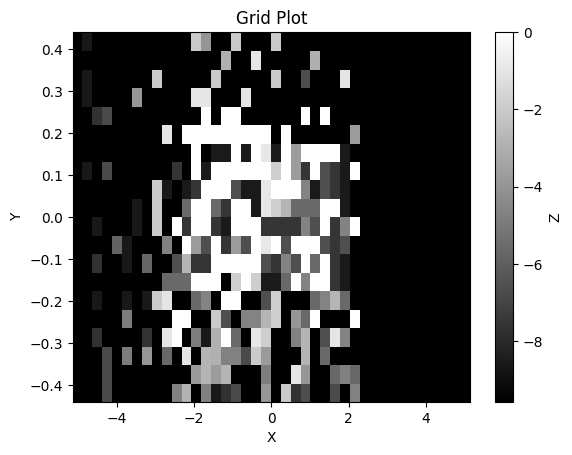

In [15]:
import pylab as plt
import numpy as np

X=[]
Y=[]
Z=[]
# Sample data
side = np.linspace(-2,2,15)
for k in pi.value_function.keys():
    X.append(k[0])
    Y.append(k[2])
    Z.append(pi.value_function[k])


X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)

# Define grid
x_unique = np.sort(np.unique(X))
y_unique = np.sort(np.unique(Y))

# Create meshgrid
X_grid, Y_grid = np.meshgrid(x_unique, y_unique)

# Interpolate Z onto grid
Z_grid = np.zeros_like(X_grid, dtype=float)
for x, y, z in zip(X, Y, Z):
    x_index = np.where(x_unique == x)[0][0]
    y_index = np.where(y_unique == y)[0][0]
    Z_grid[y_index, x_index] = z
# Plot the grid
plt.pcolor(X_grid, Y_grid, Z_grid, cmap='gray')
plt.colorbar(label='Z')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Grid Plot')
plt.show()

In [16]:
def get_optimal_action(state, optimal_policy):
        
        greedy_action, _ = max(optimal_policy[state].items(), key= lambda pair: pair[1])
        #print(greedy_action)
        return greedy_action
    

In [17]:
zero=0
ones=0

for k in pi.policy:
    zero += pi.policy[k][0]
    ones += pi.policy[k][1]

print(zero)
print(ones)

1178943
101057


In [18]:
total_steps = 0
num_episodes = 10000
cartpole = CartPoleEnv(render_mode="human")
for episode in range(0,num_episodes):
    observation, _ = cartpole.reset()
    for timestep in range(1,1000):
        action = get_optimal_action(pi.get_state(observation), pi.policy)
        observation, reward, done, terminated, info = cartpole.step(action)
        if done:
            break        

KeyboardInterrupt: 

In [1]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

In [2]:
env = gym.make('CartPole-v1')
env = DummyVecEnv([lambda: env])  # Wrap the environment

In [3]:
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 2102 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1442        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007686507 |
|    clip_fraction        | 0.0679      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.687      |
|    explained_variance   | -0.0149     |
|    learning_rate        | 0.0003      |
|    loss                 | 7.11        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00971    |
|    value_loss           | 52.2        |
-----------------------------------------
-----------------

In [52]:
# Evaluate the trained agent
env = gym.make('CartPole-v1', render_mode="human")
env = DummyVecEnv([lambda: env])  # Wrap the environment
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward}")

# Test the trained agent

for episode in range(0,10000):
    obs = env.reset()
    while(True):
        #action_ = get_optimal_action(tuple(obs), pi.policy)
        action, _states = model.predict(obs, deterministic=True)
        #print("PPO action:", action)
        #print("PI action:", action_)
        obs, rewards, dones, info = env.step(action)
        if dones:
            break
            
env.close()


Mean reward: 500.0 +/- 0.0


KeyboardInterrupt: 

In [9]:
import torch
import numpy as np

def get_value(model, observation):
    # Convert the observation to a numpy array if it's not already one
    if not isinstance(observation, np.ndarray):
        observation = np.array(observation)
    
    # Check if the observation is already in the shape expected by the model (with a batch dimension)
    # If not, add a batch dimension
    if observation.ndim == 1:
        observation = np.expand_dims(observation, axis=0)
    
    # Convert the numpy array to a PyTorch tensor
    obs_tensor = torch.tensor(observation, dtype=torch.float).to(model.device)
    
    # Get the value from the model's value network
    with torch.no_grad():  # Inference only, no gradients required
        value = model.policy.value_net(obs_tensor)
    
    # Convert the tensor to a numpy array and return the first item
    return value.cpu().numpy()[0, 0]

# Example usage
env = gym.make('CartPole-v1')
observation = env.reset()
value = get_value(model, observation)
print(f"Estimated value of the initial state: {value}")


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [54]:
import pylab as plt
import numpy as np

X=[]
Y=[]
Z=[]
# Sample data
side = np.linspace(-2,2,15)
for k in pi.value_function.keys():
    X.append(k[0])
    Y.append(k[2])
    Z.append(get_value(model, k))


X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)

# Define grid
x_unique = np.sort(np.unique(X))
y_unique = np.sort(np.unique(Y))

# Create meshgrid
X_grid, Y_grid = np.meshgrid(x_unique, y_unique)

# Interpolate Z onto grid
Z_grid = np.zeros_like(X_grid, dtype=float)
for x, y, z in zip(X, Y, Z):
    x_index = np.where(x_unique == x)[0][0]
    y_index = np.where(y_unique == y)[0][0]
    Z_grid[y_index, x_index] = z
# Plot the grid
plt.pcolor(X_grid, Y_grid, Z_grid, cmap='gray')
plt.colorbar(label='Z')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Grid Plot')
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x4 and 64x1)

In [ ]:
import gymnasium as gym

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

# Parallel environments
vec_env = make_vec_env("MountainCar-v0", n_envs=4)

model = PPO("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=25000)
model.save("ppo_cartpole")

del model # remove to demonstrate saving and loading

model = PPO.load("ppo_cartpole")

obs = vec_env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -200     |
| time/              |          |
|    fps             | 6210     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 8192     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 200        |
|    ep_rew_mean          | -200       |
| time/                   |            |
|    fps                  | 2948       |
|    iterations           | 2          |
|    time_elapsed         | 5          |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.00940301 |
|    clip_fraction        | 0.0118     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.09      |
|    explained_variance   | 0.00134    |
|    learning_rate        | 

In [11]:
import gymnasium as gym

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
vec_env = make_vec_env("CartPole-v1", n_envs=4)



model = PPO.load("ppo_cartpole")
obs = vec_env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
    vec_env.render("human")
    

KeyboardInterrupt: 

In [6]:
pip uninstall opencv-python opencv-python-headless -y

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 17.7 MB/s eta 0:00:00m eta 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.


In [9]:
import gymnasium as gym

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
vec_env = make_vec_env("CartPole-v1", n_envs=4)



model = PPO.load("ppo_cartpole")


single_env = gym.make("CartPole-v1", render_mode="human")
observation = single_env.reset()
done = False

while not done:
    action, _states = model.predict(observation)
    observation, reward, done, terminate ,info = single_env.step(action)


ValueError: You have passed a tuple to the predict() function instead of a Numpy array or a Dict. You are probably mixing Gym API with SB3 VecEnv API: `obs, info = env.reset()` (Gym) vs `obs = vec_env.reset()` (SB3 VecEnv). See related issue https://github.com/DLR-RM/stable-baselines3/issues/1694 and documentation for more information: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api

In [39]:
def func4(n, base):
    if n <= 0:
        return 0
    if n == 1:
        return base
    return base + func4(n - 1, base) + func4(n - 2, base)

# Example usage:
result = func4(6, 2)  # You can change the values of n and base as needed
print("Result:", result)


Result: 40


In [73]:
def ackermann(m, n):
    if m == 0:
        return n + 1
    elif n == 0:
        return ackermann(m - 1, 1)
    else:
        return ackermann(m - 1, ackermann(m, n - 1))

In [74]:
ackermann(1,4)

6